In [35]:
import statsmodels.formula.api as sm   
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
import json
import re
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline

Read text data (comments) and clean them

In [3]:
# function to clean emoji, stopwords, etc
def clean_text(text):

    # remove emoji
    myre = re.compile(u'('
        u'\ud83c[\udf00-\udfff]|'
        u'\ud83d[\udc00-\ude4f\ude80-\udeff]|'
        u'[\u2600-\u26FF\u2700-\u27BF])+|'
        u'\ufeff|'
        u'\ufe0f|'
        '\n', 
        re.UNICODE)
    text = myre.sub(' ', text)
    
    # clean string end
    myre = re.compile('\!+|\?+|\.+')
    text = myre.sub('.', text)

    # define stopwords  
    stop = set(stopwords.words('english'))
    
    # tokenzie    
    token = [t for t in word_tokenize(text.lower()) if (t not in stop) & (t.isalpha())]
    
    # lemmatize each token    
    lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()    
    result = []
    for t in token:
        result.append(lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(t, pos='n'), pos='v'), pos='a'))
                 
    return (' '.join(result))

In [6]:
# X values: comment threads of each channel
with open('comment_threads2.txt', 'r') as f:
    data = json.load(f)

In [12]:
# extract top level comment in each comment threads 
comments= {}
# concatenate all top level comments for each youtuber
for k in data.keys():
    toplevelcomment = ''
    for video in data[k]:
        for thread in video[0][0]['items']:
            toplevelcomment += (thread['snippet']['topLevelComment']['snippet']['textDisplay'])            
    comments[k] = toplevelcomment

In [15]:
# clean text
for k in comments.keys():
    comments[k] = clean_text(comments[k])

Read Y values (subscriber count)

In [16]:
# Y values: number of subscriber of each channel
with open('sub_count.txt', 'r') as f:
    sub = json.load(f)    

In [17]:
comment = []
Y = []

for k in comments.keys():
    comment.append(comments[k])
    Y.append(sub[k])
    
df = {'comment': comment, 'Y': Y}

Let us use tf-idf to calculate term frequency matrix of given text

In [19]:
# set max feature to 100 only
tfidf_vectorizer = TfidfVectorizer(max_features=100, vocabulary = None)
X = tfidf_vectorizer.fit_transform(df['comment']).toarray() # tfidf matrix
vocab_attribute = tfidf_vectorizer.vocabulary_ # attributes
X_df = pd.DataFrame(X, columns=vocab_attribute) #make datafram from tfidf matrix

In [42]:
print 'Top 100 term by tfidf are: ' 
for key in vocab_attribute.keys():
    print key + ',',

Top 100 term by tfidf are: 
want, friend, much, lipstick, also, video, could, guy, product, still, year, start, put, cute, miss, one, omg, would, first, talia, get, amaze, like, hair, need, long, nice, hi, new, best, never, life, people, happy, love, take, beautiful, always, see, hope, ca, live, pretty, go, keep, thank, tell, give, im, skin, back, buy, wish, every, color, good, use, foundation, awesome, palette, many, gorgeous, ur, try, face, way, help, lol, lot, look, well, makeup, thing, think, anyone, eye, watch, wear, tutorial, feel, melissa, say, favorite, really, great, work, make, lip, even, ever, wait, girl, channel, share, find, please, day, time, come, know,


Let's check how each feature correlates with Y values

In [23]:
corr = []
label = []
i=0
for key in vocab_attribute.keys():
    corr.append(np.corrcoef(X[:,i], Y)[0,1])
    label.append(key)
    i +=1

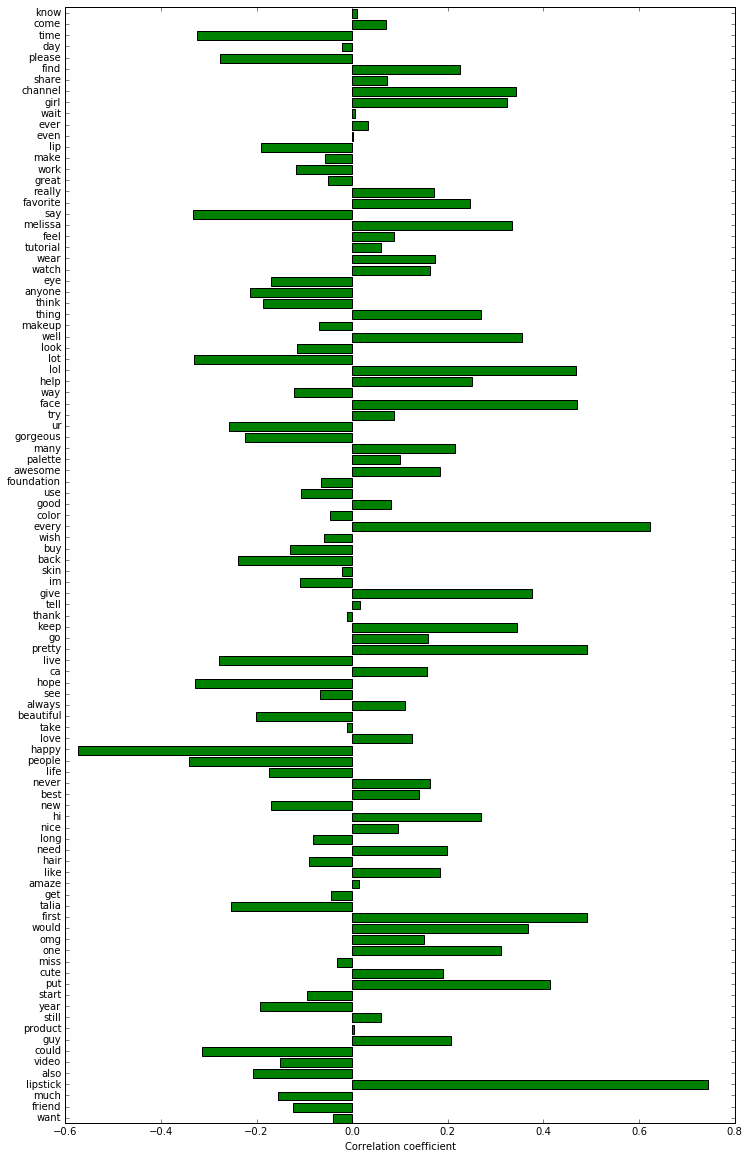

In [56]:
# plot correlation coefficient
ind = np.arange(len(label))
f, ax = plt.subplots(figsize=(12,20))
rects = ax.barh(ind, corr, color='g')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(label, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
plt.show()


The correlation coefficients range from -0.6 to 0.78. It looks like half of the features have some kind of positive correlations and half negative. Let's try picking features with correlation coefficient greater than 0.4 or less than -0.4.

In [58]:
term_chosen = []
for i in range(len(corr)):
    if abs(corr[i]) > 0.4:
        print (label[i], corr[i]),
        term_chosen.append(label[i])

(u'lipstick', 0.74495817619107507) (u'put', 0.41396796654968643) (u'first', 0.49004592302724981) (u'happy', -0.57348826526163588) (u'pretty', 0.49028075919764869) (u'every', 0.62267461819553682) (u'face', 0.46961789642095025) (u'lol', 0.46861270578948411)


Let's build a simple linear regression with the chosen features. 

Normalize Y to avoid large beta estimates.

In [36]:
# normalize Y
Y_normalized = sklearn.preprocessing.normalize(Y)[0]

C:\Users\Anh\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [61]:
result = sm.OLS(Y_normalized, X_df[term_chosen] ).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     23.41
Date:                Mon, 05 Dec 2016   Prob (F-statistic):           2.64e-11
Time:                        02:36:33   Log-Likelihood:                 55.510
No. Observations:                  40   AIC:                            -95.02
Df Residuals:                      32   BIC:                            -81.51
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
lipstick       4.1320      0.790      5.232      0.000         2.523     5.741
put           -0.3727      0.868     -0.429      0.671        -2.141     1.396
first          0.1267      1.621      0.078      0.938        -3.175     3.429
happy         -0.6382      0.233     -2.739      0.010        -1.113    -0.164
pretty        -1.4139      0.593     -2.384      0.023        -2.622    -0.206
every          1.0432      0.295      3.542      0.001         0.443     1.643
face           0.5124      0.371      1.382      0.177        -0.243     1.268
lol           -0.2011      0.412     -0.488      0.629        -1.040     0.638
==============================================================================
Omnibus:                        3.906   Durbin-Watson:                   1.579
Prob(Omnibus):                  0.142   Jarque-Bera (JB):                3.358
Skew:                           0.200   Prob(JB):                        0.187
Kurtosis:                       4.362   Cond. No.                         36.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With this linear regression model, attributes 'lipstick', 'happy', 'pretty', 'every' are significant. The model has high R-squared which seems to predict Y well.

Things to try as for next step:
1. Different way to select features
2. Expand sample size; divide into train and test set